# DASC 512 - Homework 6 Solutions
Note: There is no single correct answer in this homework. This is one of many possible solutions representing how the instructor worked through it. Yours may be (and probably should be) different.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.stats.api as sms

sns.set_style('whitegrid')

In [2]:
crime = pd.read_csv('UScrime.csv')

In [3]:
crime.head(1)

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.51,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791


In [11]:
crime = crime.rename({'M.F':'MF'}, axis=1)  # The . can cause problems with Patsy

In [12]:
y = crime['Crime']

In [13]:
X = crime.drop('Crime', axis=1)

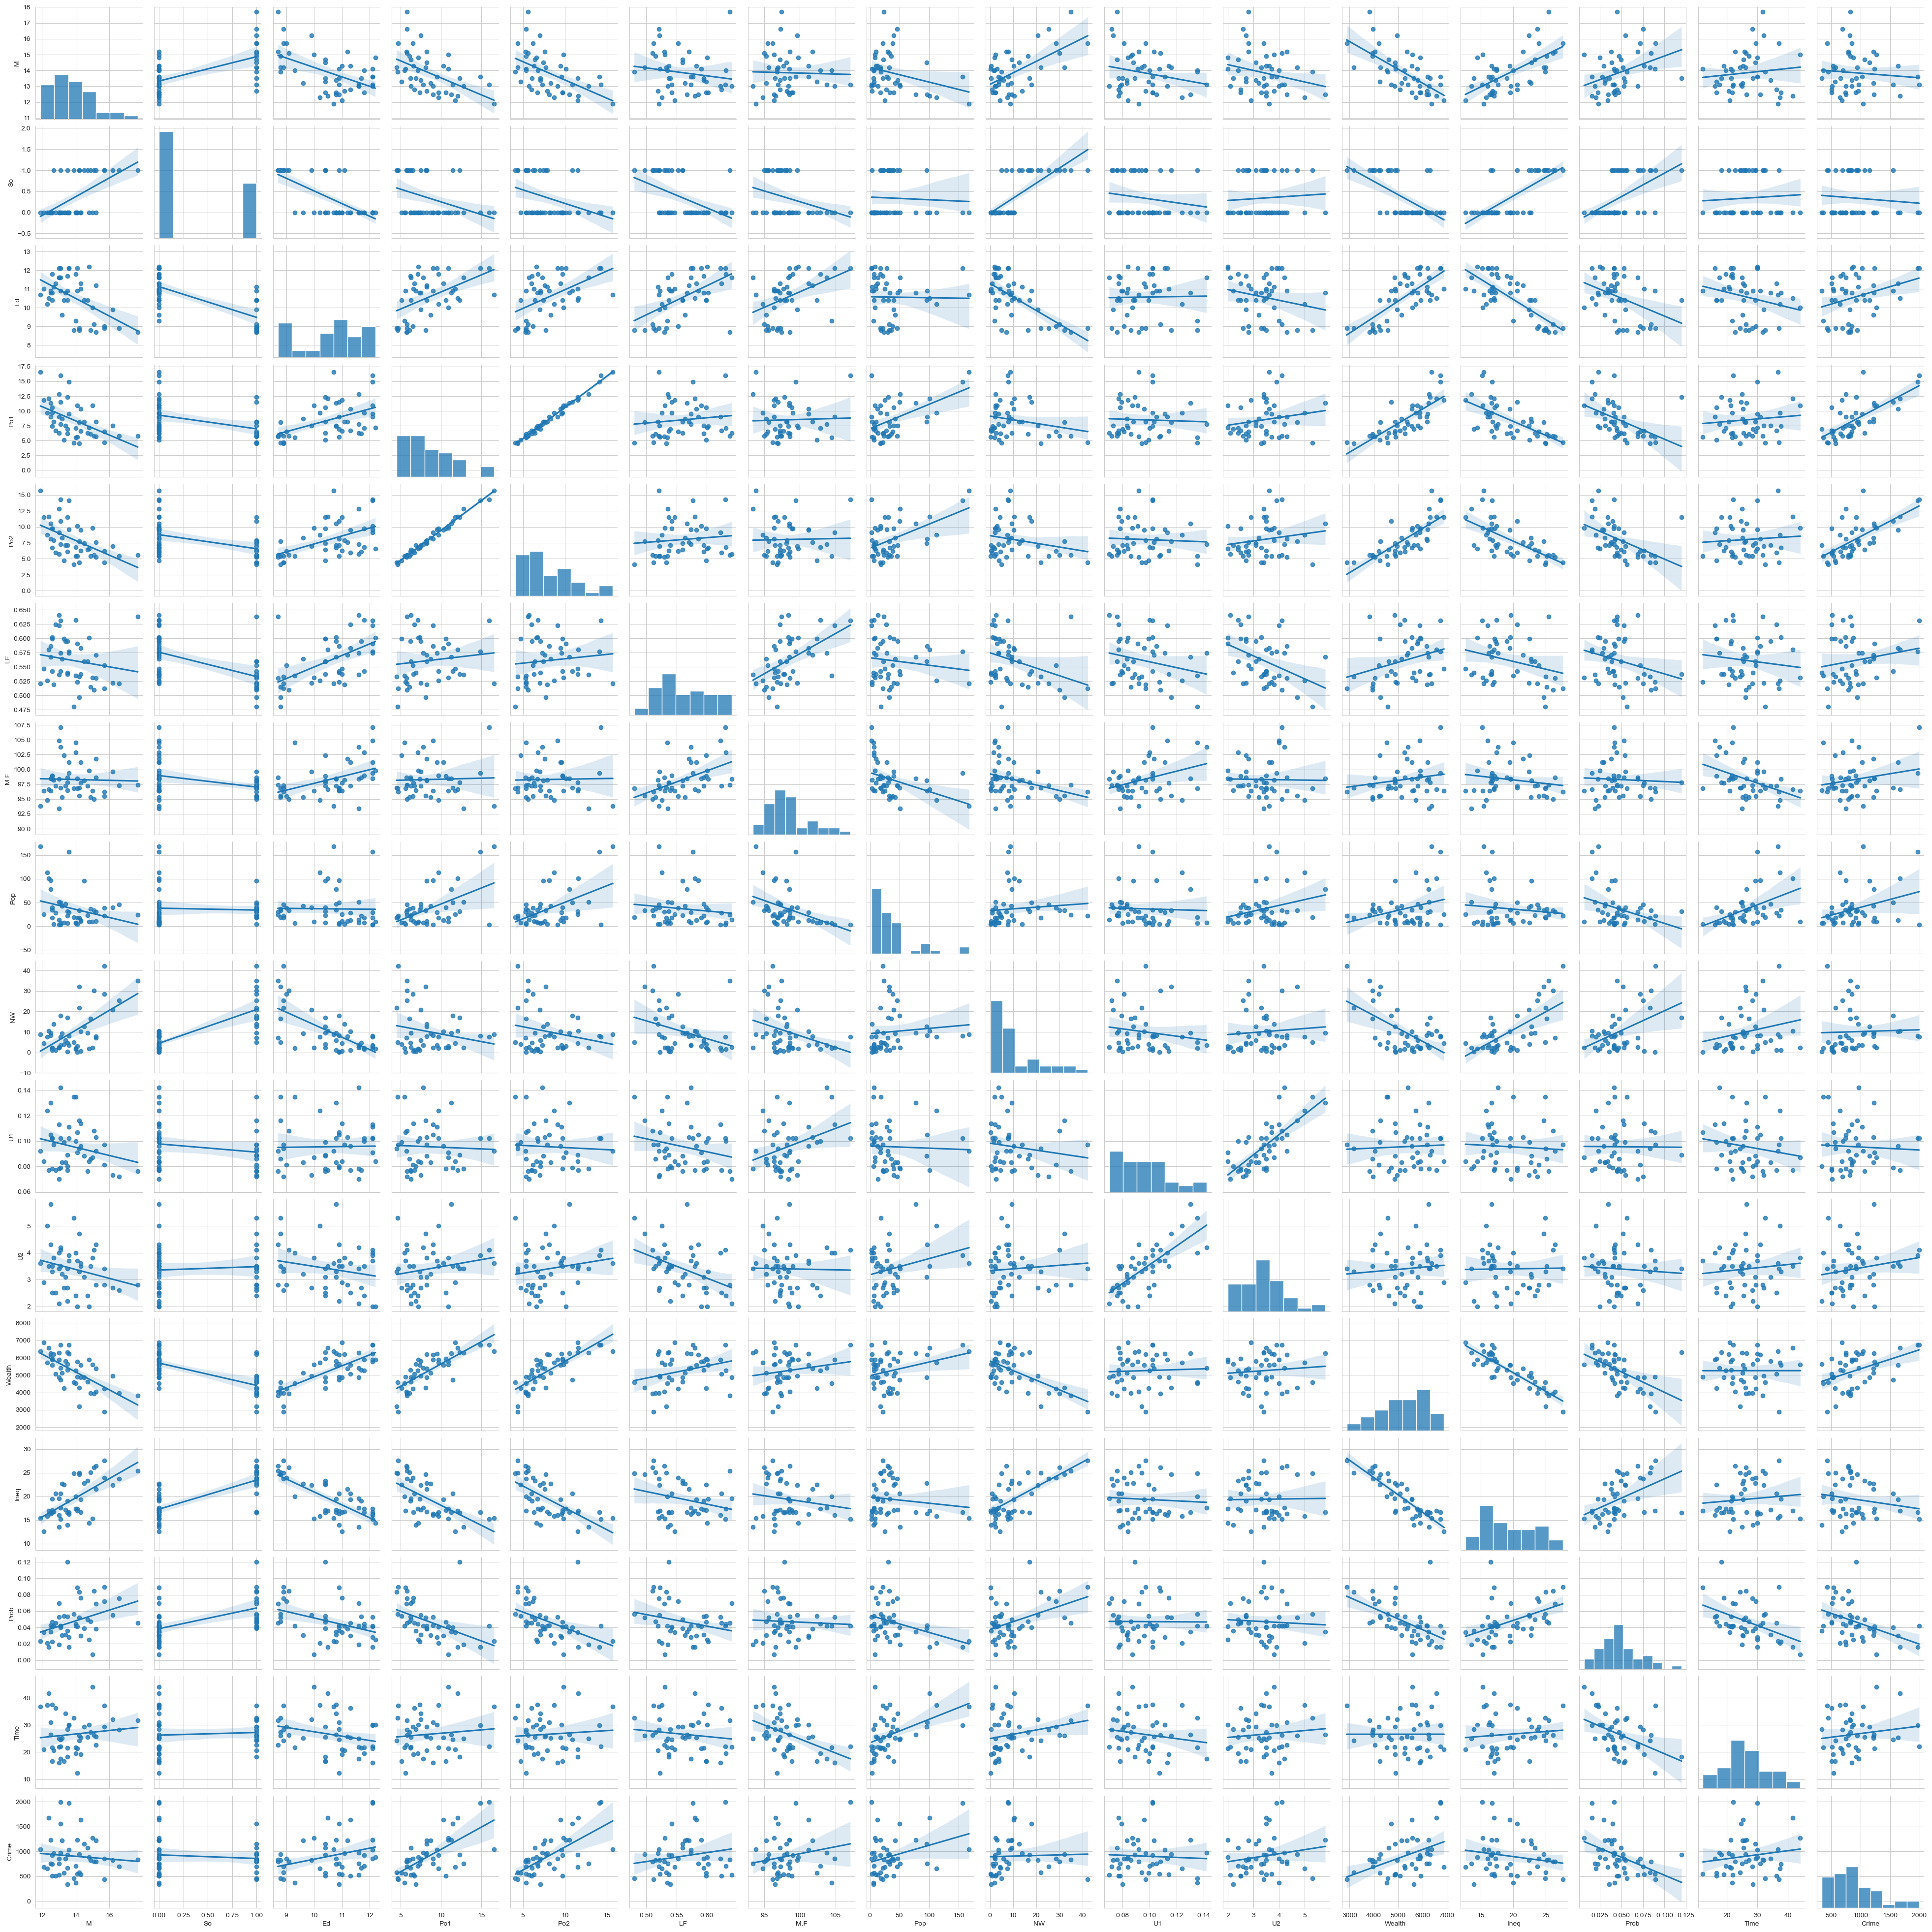

In [6]:
sns.pairplot(crime, kind='reg')

# Method: Stepwise Regression with Backward Elimination

In [14]:
formula = 'Crime ~ '
for col in X.columns:
    formula += col + ' + '
formula = formula[:-3]

In [15]:
model = smf.ols(formula, crime).fit()
print(model.rsquared_adj)
print(abs(model.pvalues).sort_values(ascending=False))

0.7078061575025096
So           0.979765
LF           0.654654
Time         0.630708
Pop          0.573845
NW           0.521279
MF           0.398995
Wealth       0.360754
Po2          0.358830
U1           0.176238
Po1          0.078892
U2           0.050161
M            0.043443
Prob         0.040627
Ed           0.004861
Ineq         0.003983
Intercept    0.000893
dtype: float64


We'll remove the terms with the highest p-value one-by-one until BIC stops decreasing or the R2a goes below the specified 0.73 limit.

In [16]:
model = smf.ols(formula + ' - So - Time - LF - NW - Po2 - Pop - Wealth - MF - U1', crime).fit()
print(model.rsquared_adj)
print(model.aic)
print(model.bic)
print(abs(model.pvalues).sort_values(ascending=False))

0.7307462777965564
638.1661296781123
651.1171628900827
U2           3.483130e-02
Prob         1.711387e-02
M            3.054440e-03
Ed           8.072016e-05
Ineq         1.879377e-05
Intercept    1.715273e-06
Po1          2.561505e-10
dtype: float64


In [17]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.731   
Dependent Variable:   Crime            AIC:                638.1661
Date:                 2023-02-22 10:18 BIC:                651.1172
No. Observations:     47               Log-Likelihood:     -312.08 
Df Model:             6                F-statistic:        21.81   
Df Residuals:         40               Prob (F-statistic): 3.42e-11
R-squared:            0.766            Scale:              40276.  
-------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept -5040.5050  899.8434 -5.6015 0.0000 -6859.1563 -3221.8537
M           105.0196   33.2993  3.1538 0.0031    37.7193   172.3199
Ed          196.4712   44.7544  4.3900 0.0001   106.0192   286.9232
Po1         115.0242   13.7536  8.3632 0.0000    87.2272   142.8212
U2           89.3660   40.9057  2.1847 0.0348     6.6926   172.0395
Ineq         67.6532   13.9357  4.8547 0.0000    39.4880    95.8184
Prob      -3801.8363 1528.0973 -2.4880 0.0171 -6890.2362  -713.4364
-------------------------------------------------------------------
Omnibus:               2.955         Durbin-Watson:           1.932
Prob(Omnibus):         0.228         Jarque-Bera (JB):        2.360
Skew:                  -0.001        Prob(JB):                0.307
Kurtosis:              4.098         Condition No.:           1452 
===================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

#### Assumption 1 & 2

In [18]:
crime['pred'] = model.fittedvalues

In [19]:
crime['resid'] = model.resid

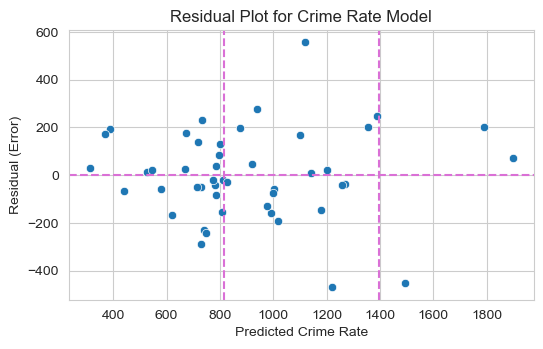

In [20]:
fig, ax = plt.subplots(figsize=(6,3.5))
sns.scatterplot(data=crime, x='pred', y='resid', ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('Predicted Crime Rate')
ax.set_ylabel('Residual (Error)')
ax.set_title('Residual Plot for Crime Rate Model')
plt.savefig('2-resid-by-pred.svg')
plt.show()

#### Assumption 3

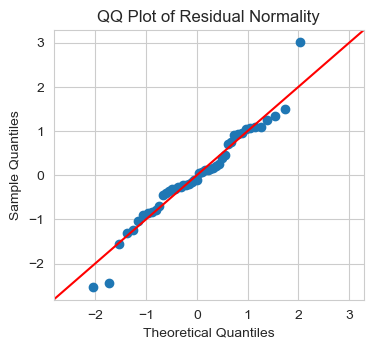

In [21]:
fig, ax = plt.subplots(figsize=(4,3.5))
smg.qqplot(model.resid, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot of Residual Normality')
plt.savefig('2-qqplot.svg')
plt.show()

There's some outliers but most of the data is approximately normal.

In [22]:
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9689844846725464, pvalue=0.24230080842971802)

That seems normal.

#### Assumption 4
It's not clear that any data exists in this dataset that references the order collected in any meaningful way. We'll have to make this assumption without checking it.

#### Outliers and Influence Points

In [23]:
influ = model.get_influence()

In [24]:
crime['stand_resid'] = influ.resid_studentized_internal
crime['stud_resid'] = influ.resid_studentized_external

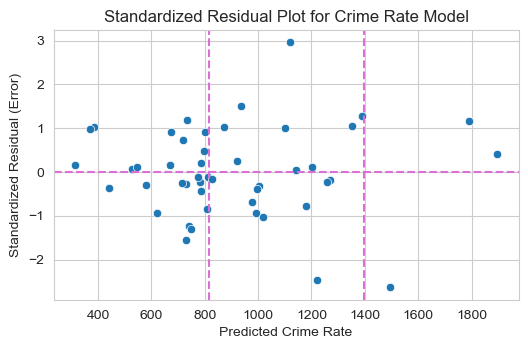

In [25]:
fig, ax = plt.subplots(figsize=(6,3.5))
sns.scatterplot(data=crime, x='pred', y='stand_resid', ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('Predicted Crime Rate')
ax.set_ylabel('Standardized Residual (Error)')
ax.set_title('Standardized Residual Plot for Crime Rate Model')
plt.savefig('2-outliers.svg')
plt.show()

In [26]:
crime[crime['stand_resid'] > 2]

,M,So,Ed,Po1,Po2,LF,MF,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime,pred,resid,stand_resid,stud_resid
10,12.4,0,10.5,12.1,11.6,0.58,96.6,101,10.6,0.077,3.5,6570,17.0,0.016201,41.6,1674,1117.770249,556.229751,2.957209,3.303355


In [27]:
crime[crime['stand_resid'] < -2]

,M,So,Ed,Po1,Po2,LF,MF,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime,pred,resid,stand_resid,stud_resid
18,13.0,0,11.6,12.8,12.8,0.536,93.4,51,2.4,0.078,3.4,6270,13.5,0.019099,24.9008,750,1220.676663,-470.676663,-2.459366,-2.635881
28,11.9,0,10.7,16.6,15.7,0.521,93.8,168,8.9,0.092,3.6,6370,15.4,0.023400,36.7009,1043,1495.485604,-452.485604,-2.634960,-2.862034


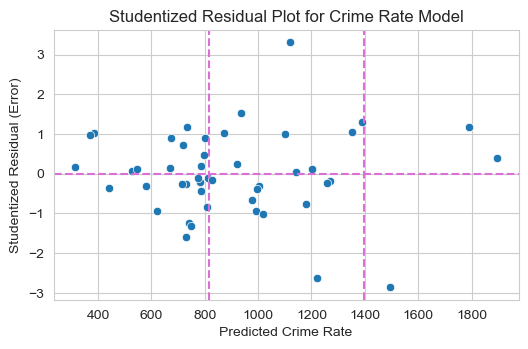

In [28]:
fig, ax = plt.subplots(figsize=(6,3.5))
sns.scatterplot(data=crime, x='pred', y='stud_resid', ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('Predicted Crime Rate')
ax.set_ylabel('Studentized Residual (Error)')
ax.set_title('Studentized Residual Plot for Crime Rate Model')
plt.savefig('2-studentized.svg')
plt.show()

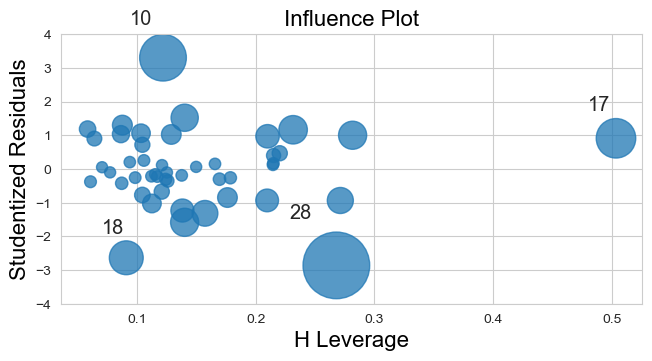

In [29]:
fig, ax = plt.subplots(figsize=(7.5,3.5))
smg.influence_plot(model, ax=ax)
ax.set_ylim(-4,4)
plt.savefig('2-leverage.svg')
plt.show()

#### Summary plots

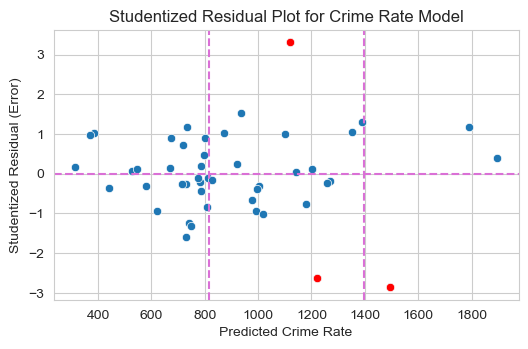

In [30]:
fig, ax = plt.subplots(figsize=(6,3.5))
sns.scatterplot(data=crime, x='pred', y='stud_resid', ax=ax)
sns.scatterplot(data=crime.loc[[28,10,18]], x='pred', y='stud_resid', ax=ax, color='red')
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3 * (xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('Predicted Crime Rate')
ax.set_ylabel('Studentized Residual (Error)')
ax.set_title('Studentized Residual Plot for Crime Rate Model')
plt.savefig('2-influence_highlighted.svg')
plt.show()

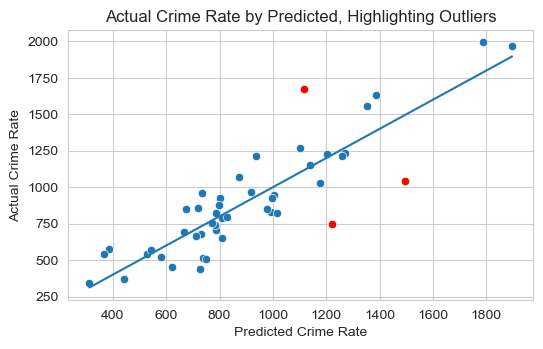

In [31]:
fig, ax = plt.subplots(figsize=(6,3.5))
sns.scatterplot(data=crime, x='pred', y='Crime', ax=ax, ci=None)
sns.lineplot(data=crime, x='pred', y='pred', ax=ax)
sns.scatterplot(data=crime.loc[[10,18,28]], x='pred', y='Crime', ax=ax, color='red')
ax.set_xlabel('Predicted Crime Rate')
ax.set_ylabel('Actual Crime Rate')
ax.set_title('Actual Crime Rate by Predicted, Highlighting Outliers')
plt.savefig('2-actual-by-pred.svg')
plt.show()

#### Variance Inflation Factor

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
from patsy import dmatrices
y, X = dmatrices('Crime ~ M + Ed + Po1 + U2 + Ineq + Prob', crime, return_type='dataframe')

In [34]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, ii) \
              for ii in range(X.shape[1])]
vif['features'] = X.columns
print(vif.to_latex())

\begin{tabular}{lrl}
\toprule
{} &         VIF &   features \\
\midrule
0 &  944.889099 &  Intercept \\
1 &    2.000244 &          M \\
2 &    2.862893 &         Ed \\
3 &    1.908124 &        Po1 \\
4 &    1.363074 &         U2 \\
5 &    3.530429 &       Ineq \\
6 &    1.378714 &       Prob \\
\bottomrule
\end{tabular}



C:\Users\weimp\AppData\Local\Temp\ipykernel_24956\106291453.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vif.to_latex())


In [35]:
crime['Prob'].describe()

count    47.000000
mean      0.047091
std       0.022737
min       0.006900
25%       0.032701
50%       0.042100
75%       0.054450
max       0.119804
Name: Prob, dtype: float64

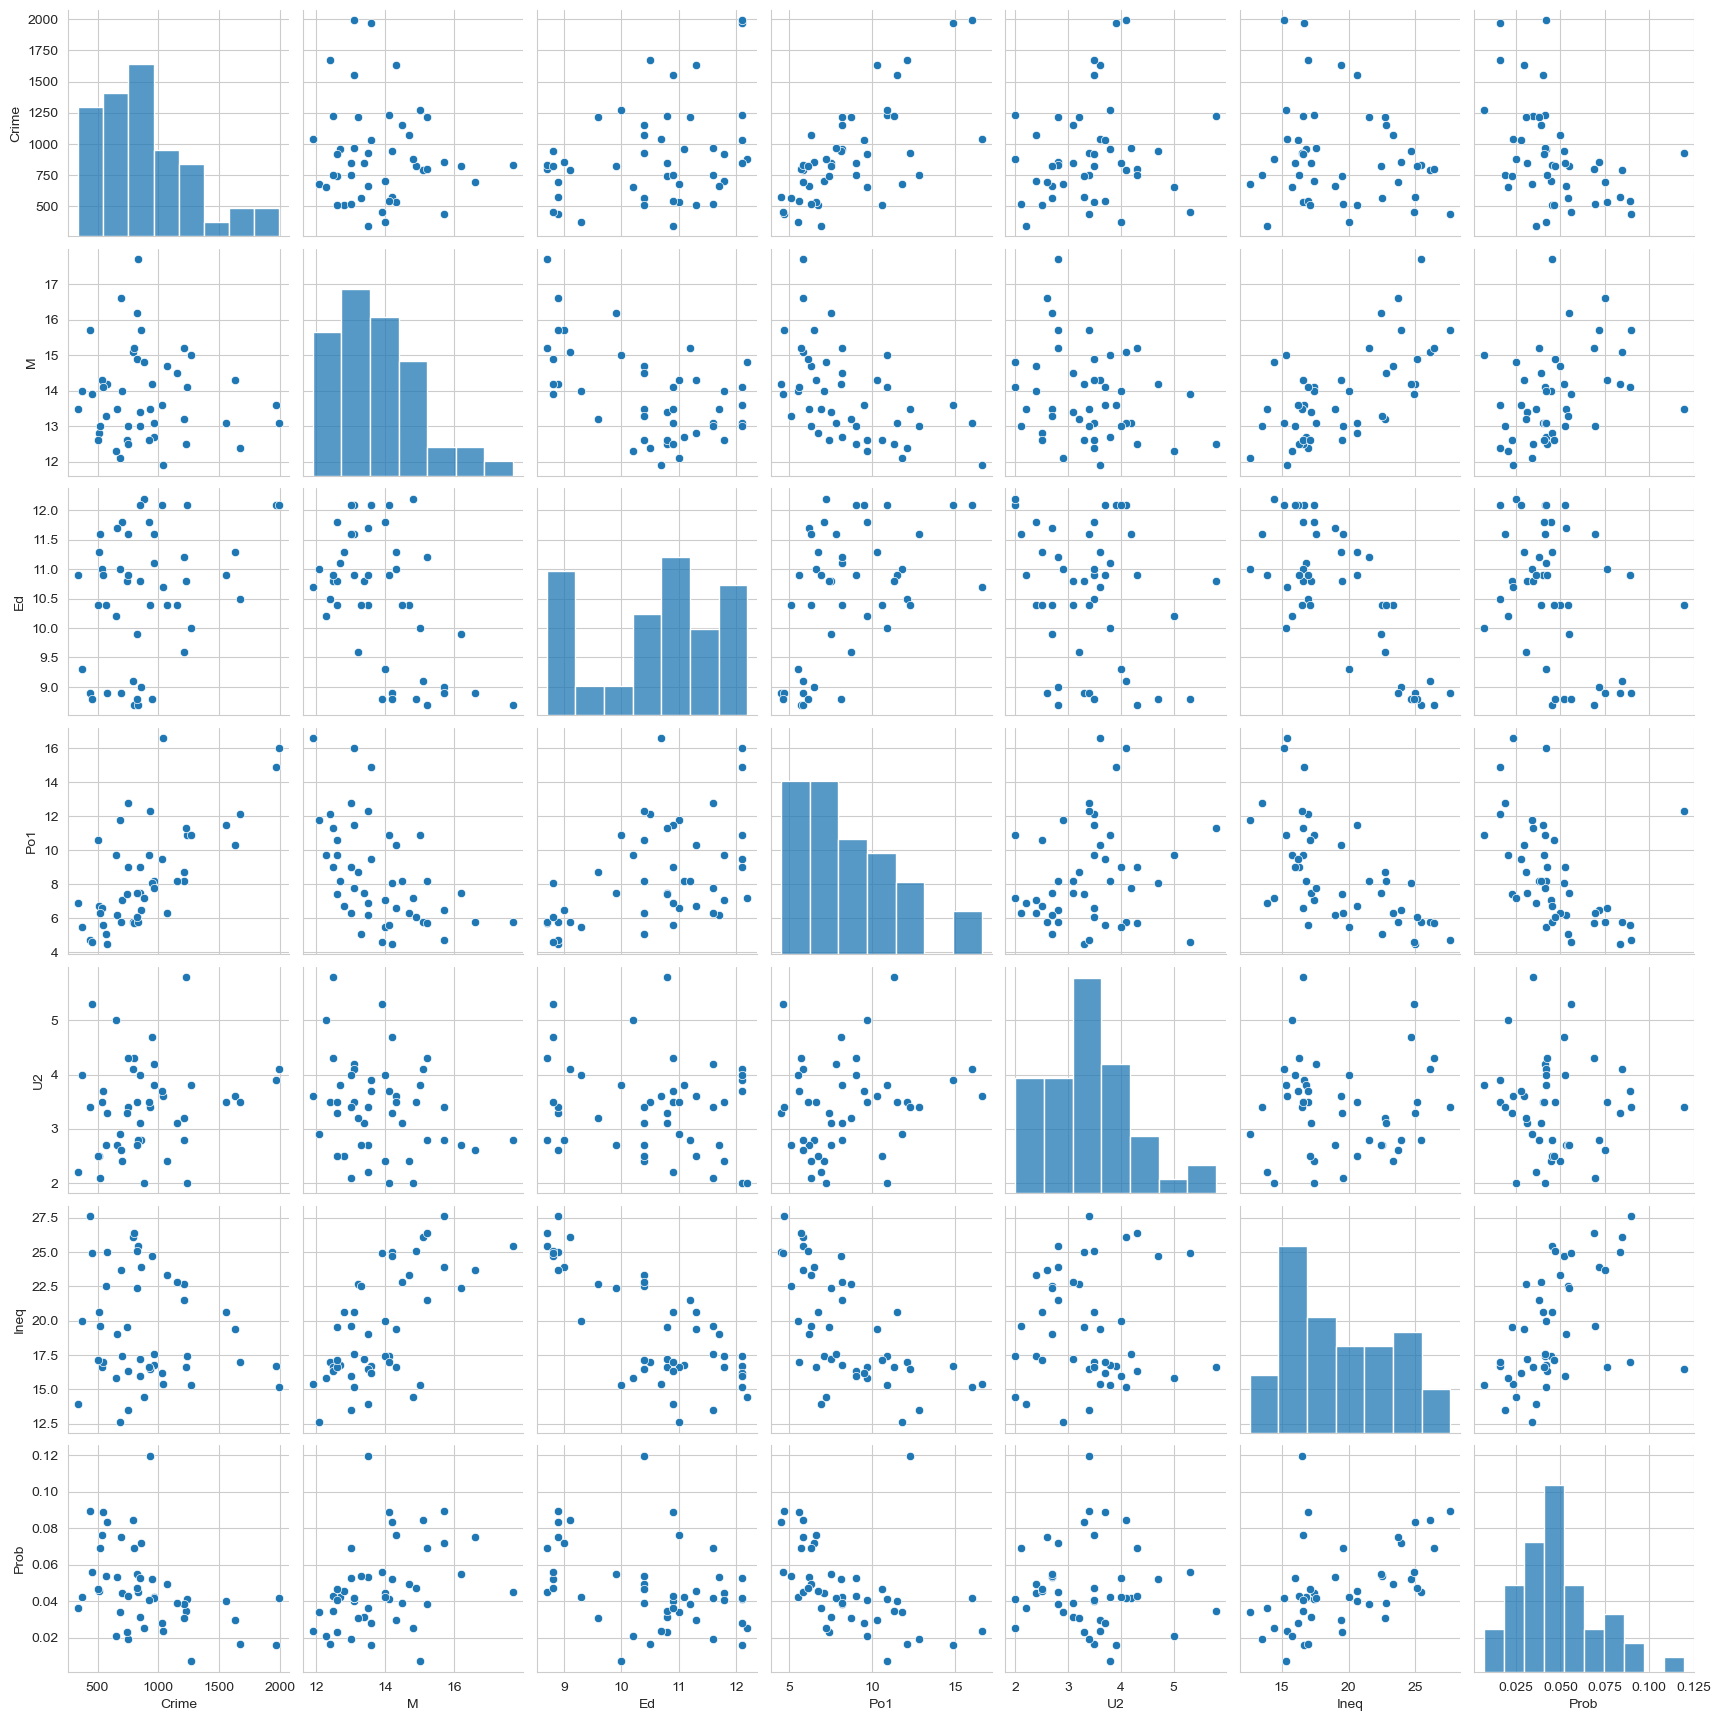

In [36]:
sns.pairplot(crime[['Crime','M','Ed','Po1','U2','Ineq','Prob']])
plt.show()

# Example: Using Lasso
See below for another method of building a model. This results in one with a lower R2a, so I don't expect anyone to have used this method, but this may be useful for Homework 7 and the Final Project.

In [37]:
from sklearn.linear_model import Lasso

In [83]:
crime = pd.read_csv('UScrime.csv')
crime = crime.rename({'M.F':'MF'}, axis=1)
X = crime.drop('Crime', axis=1)
y = crime['Crime']

In [100]:
Xz = stats.zscore(X, ddof=1)

First I looped through a bunch of values of $\alpha$ and calculated the coefficients.

In [125]:
alpha_rng = np.arange(0.1, 100, 0.1)

In [126]:
coefs = []
for alpha in alpha_rng:
    lm = Lasso(alpha=alpha, max_iter=10000)
    lm.fit(Xz, y)
    coefs.append(lm.coef_)

In [127]:
coefs = pd.DataFrame(data=np.array(coefs), columns=Xz.columns, index=alpha_rng)

In [128]:
coefs.head()

,M,So,Ed,Po1,Po2,LF,MF,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time
0.1,110.307986,-0.000000,208.766469,549.691817,-280.399101,-24.451503,51.124464,-27.821329,40.923890,-103.039956,140.775887,90.985379,280.894876,-109.072872,-22.839601
0.2,110.343948,0.244293,206.949147,526.663635,-255.422599,-22.701595,51.159026,-27.732982,39.238447,-101.661735,140.177084,89.688315,280.584236,-107.590331,-21.175701
0.3,110.324469,1.276594,205.088488,503.599972,-230.258193,-20.643387,51.089623,-27.647074,37.244843,-99.965238,139.406676,88.135127,279.897212,-106.192352,-19.440812
0.4,110.304791,2.308647,203.229184,480.571167,-205.129154,-18.586618,51.019463,-27.561456,35.252663,-98.268884,138.635664,86.581430,279.209426,-104.795700,-17.707626
0.5,110.284995,3.340554,201.370678,457.562898,-180.020951,-16.530696,50.948859,-27.476009,33.261321,-96.572615,137.864296,85.027433,278.521192,-103.399830,-15.975444


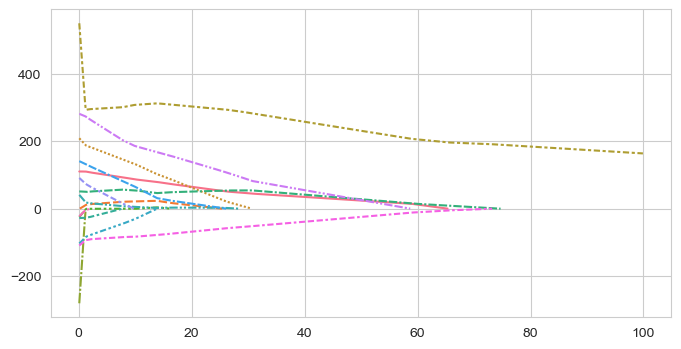

In [129]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=coefs[coefs != 0], ax=ax, legend=False)
plt.show()

Now I'll generate OLS models suggested by each Lasso run.

In [131]:
def form(alpha):
    row = int(10 * alpha - 1)
    non_zero_coefs = coefs.iloc[row][coefs.iloc[row] != 0]
    formula = 'Crime ~ '
    for term in non_zero_coefs.index:
        formula += term + ' + '
    return formula[:-3]

Let's see what model has the lowest BIC.

In [132]:
best_bic = 999999
best_alpha = 0
for alpha in alpha_rng:
    model = smf.ols(form(alpha), crime).fit()
    if model.bic <= best_bic:
        best_bic = model.bic
        best_alpha = alpha
print(best_alpha, best_bic)

30.6 654.1592416809407


#### Iterative experimenting with OLS models

Now I'll see if backward elimination can improve the model according to BIC. I'm using BIC because I want a smaller model.

In [133]:
form(30.6)

'Crime ~ M + Ed + Po1 + MF + Ineq + Prob'

In [134]:
model = smf.ols(form(30.6), crime).fit()

In [135]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.713   
Dependent Variable:   Crime            AIC:                641.2082
Date:                 2023-02-22 11:16 BIC:                654.1592
No. Observations:     47               Log-Likelihood:     -313.60 
Df Model:             6                F-statistic:        20.02   
Df Residuals:         40               Prob (F-statistic): 1.20e-10
R-squared:            0.750            Scale:              42970.  
-------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept -5238.6776 1162.7065 -4.5056 0.0001 -7588.5951 -2888.7601
M            73.0071   32.5923  2.2400 0.0307     7.1357   138.8785
Ed          125.1550   49.6470  2.5209 0.0158    24.8146   225.4954
Po1         122.5611   13.9322  8.7970 0.0000    94.4031   150.7191
MF           17.2086   12.2709  1.4024 0.1685    -7.5917    42.0090
Ineq         65.0671   14.5754  4.4642 0.0001    35.6092    94.5251
Prob      -3944.7148 1579.0221 -2.4982 0.0167 -7136.0375  -753.3922
-------------------------------------------------------------------
Omnibus:               1.303         Durbin-Watson:           2.009
Prob(Omnibus):         0.521         Jarque-Bera (JB):        0.573
Skew:                  -0.193        Prob(JB):                0.751
Kurtosis:              3.378         Condition No.:           5337 
===================================================================
* The condition number is large (5e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [136]:
smf.ols(form(30.6) + ' - MF', crime).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.706   
Dependent Variable:   Crime            AIC:                641.4641
Date:                 2023-02-22 11:16 BIC:                652.5650
No. Observations:     47               Log-Likelihood:     -314.73 
Df Model:             5                F-statistic:        23.09   
Df Residuals:         41               Prob (F-statistic): 5.93e-11
R-squared:            0.738            Scale:              43983.  
-------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept -4064.5740  816.2794 -4.9794 0.0000 -5713.0837 -2416.0643
M            79.6887   32.6200  2.4429 0.0190    13.8112   145.5662
Ed          160.1528   43.4221  3.6883 0.0007    72.4601   247.8454
Po1         121.2291   14.0627  8.6206 0.0000    92.8289   149.6292
Ineq         68.3103   14.5594  4.6918 0.0000    38.9069    97.7136
Prob      -3867.2709 1596.5519 -2.4223 0.0199 -7091.5728  -642.9690
-------------------------------------------------------------------
Omnibus:               3.321         Durbin-Watson:           2.157
Prob(Omnibus):         0.190         Jarque-Bera (JB):        2.259
Skew:                  -0.382        Prob(JB):                0.323
Kurtosis:              3.755         Condition No.:           1440 
===================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

This looks pretty good. This is slightly smaller than the stepwise model, and it has slightly higher BIC, but this method is usable for a larger design space.